In [1]:
import os
import numpy as np
import openpyxl
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

ruta = os.path.join('.', 'datos', 'PercMultAplicado.xlsx')
datos = pd.read_excel(ruta)

In [2]:
datos

,Entidad,Monto,Mensualidad,Plazo (años),Tasa anual,Ingreso mensual,Antigüedad laboral (meses),Mora
0,Sinaloa,299200,6277.86,20,0.25,33911.00,58,SI
1,Michoacán de Ocampo,281100,9373.58,20,0.40,112783.48,149,NO
2,Nuevo León,268800,8963.43,20,0.40,33186.96,134,NO
3,Guerrero,256600,9106.81,5,0.35,51118.90,77,NO
4,Yucatán,256500,5381.92,20,0.25,197168.90,5,SI
...,...,...,...,...,...,...,...,...
995,Baja California Sur,18700,473.05,15,0.30,2861.95,150,NO
996,Baja California,16600,416.11,20,0.30,3618.79,25,SI
997,Colima,16400,582.04,5,0.35,3770.64,107,NO
998,Morelos,14600,384.88,10,0.30,1751.91,60,NO


In [3]:
# ------------------------ limpieza de datos ------------------------ #
datos.columns = datos.columns.str.lower()
datos['carga'] = datos['mensualidad'] / datos['ingreso mensual']
datos['mora_bool'] = datos.mora.replace({'SI': 1, 'NO': 0})
datos.rename(columns={'antigüedad laboral (meses)': 'antiguedad_laboral_meses'}, inplace=True)

subset = datos[['monto', 'antiguedad_laboral_meses', 'carga', 'mora_bool']]

### Estandarización de datos

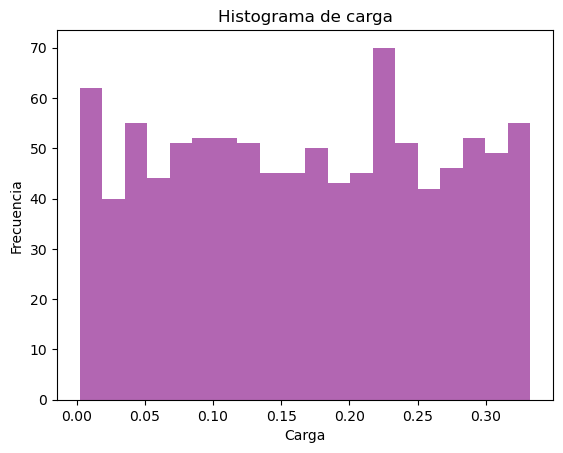

In [4]:
# columna "carga"
plt.hist(subset.carga, bins=20, color='purple', alpha=0.6)
plt.title('Histograma de carga')
plt.xlabel('Carga')
plt.ylabel('Frecuencia')
plt.show()

In [5]:
print("mínimo:", subset.carga.min(), "máximo:", subset.carga.max())

mínimo: 0.0021474142693629914 máximo: 0.3327304085775127


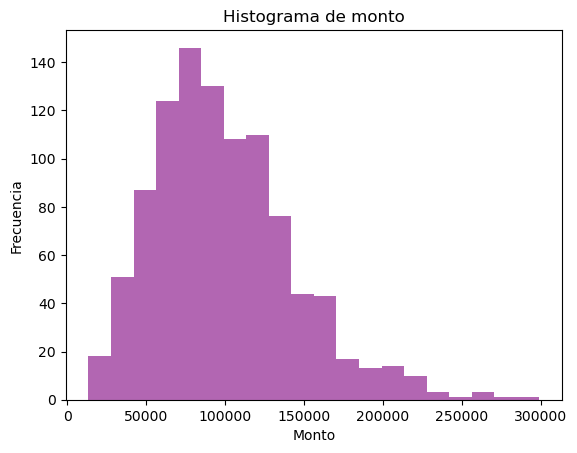

In [6]:
# columna "monto"
plt.hist(subset.monto, bins=20, color='purple', alpha=0.6)
plt.title('Histograma de monto')
plt.xlabel('Monto')
plt.ylabel('Frecuencia')
plt.show()

In [7]:
# calcular raíz cuadrada de monto
subset['monto_sqrt'] = np.sqrt(subset.monto)

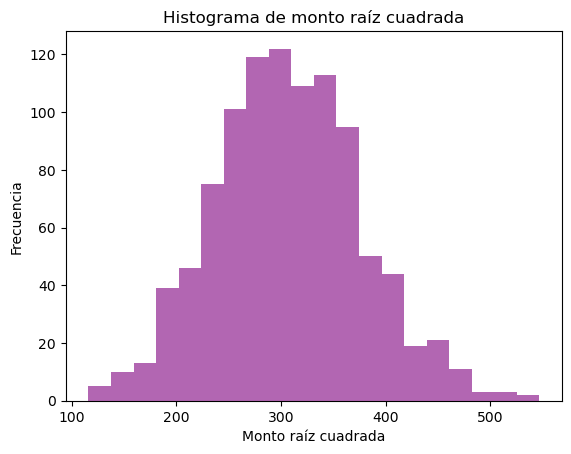

In [8]:
plt.hist(subset.monto_sqrt, bins=20, color='purple', alpha=0.6)
plt.title('Histograma de monto raíz cuadrada')
plt.xlabel('Monto raíz cuadrada')
plt.ylabel('Frecuencia')
plt.show()

In [9]:
print("mínimo:", subset.monto_sqrt.min(), "máximo:", subset.monto_sqrt.max())

mínimo: 116.1895003862225 máximo: 546.9917732470938


In [10]:
# monto con min-max
subset['monto_norm'] = (subset.monto_sqrt - 100) / (600 - 100)

In [11]:
print("mínimo:", subset.monto_norm.min(), "máximo:", subset.monto_norm.max())

mínimo: 0.03237900077244501 máximo: 0.8939835464941875


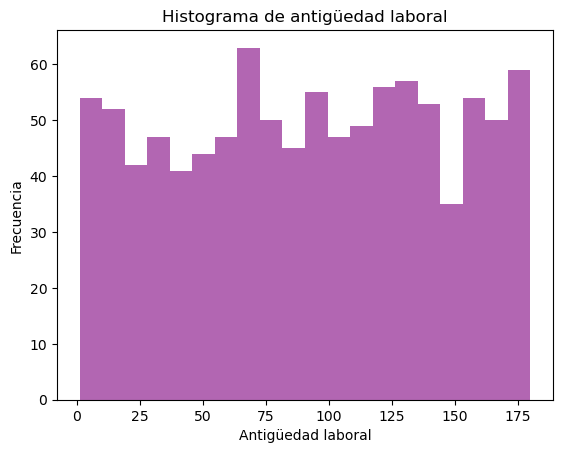

In [12]:
# columna "antiguedad_laboral_meses"
plt.hist(subset.antiguedad_laboral_meses, bins=20, color='purple', alpha=0.6)
plt.title('Histograma de antigüedad laboral')
plt.xlabel('Antigüedad laboral')
plt.ylabel('Frecuencia')
plt.show()

In [13]:
# antiguedad_laboral_meses con min-max
subset['al_norm'] = (subset.antiguedad_laboral_meses - 0) / (subset.antiguedad_laboral_meses.max() - 0)

In [14]:
print("mínimo:", subset.al_norm.min(), "máximo:", subset.al_norm.max())

mínimo: 0.005555555555555556 máximo: 1.0


In [15]:
# subset final normalizado
subset_norm = subset[['carga', 'monto_norm', 'al_norm', 'mora_bool']]
subset_norm

,carga,monto_norm,al_norm,mora_bool
0,0.185128,0.893984,0.322222,1
1,0.083111,0.860377,0.827778,0
2,0.270089,0.836919,0.744444,0
3,0.178150,0.813114,0.427778,0
4,0.027296,0.812917,0.027778,1
...,...,...,...,...
995,0.165289,0.073496,0.833333,0
996,0.114986,0.057682,0.138889,1
997,0.154361,0.056125,0.594444,0
998,0.219692,0.041661,0.333333,0


### Proceso par generar los sets de entrenamiento y testeo

In [16]:
from generacion_sets import generar_sets_df

# ------------------------ generación de sets ------------------------ #
train, test = generar_sets_df(df=subset_norm, col_bool='mora_bool', prop=0.7, prop_interna_f=0.8, prop_interna_t=0.2)

In [17]:
# ------------------------ información de los sets ------------------------ #
print("train:", train.shape)
print("test:", test.shape)

train: (700, 4)
test: (300, 4)


In [18]:
train.mora_bool.value_counts()

0    560
1    140
Name: mora_bool, dtype: int64

In [19]:
test.mora_bool.value_counts()

0    231
1     69
Name: mora_bool, dtype: int64

### Entrenamiento de la red neuronal

In [20]:
# -------------------- # Preparación de los datos # ---------------------- #

# Separar en X y d
X_train = train[['carga', 'monto_norm', 'al_norm']].to_numpy().astype(float)
d_train = train['mora_bool'].to_numpy().astype(float)

In [21]:
# ------------------------------ # Fase 1 # ------------------------------ #
# definiendo las dimensiones
N = X_train.shape[1]  #N es el número de entradas
L = 4 #  neuronas en la capa oculta
M = 1 #  neuronas en la capa de salida

# inicializando los pesos (de inicio, son aleatorios)
w_h = np.random.uniform(-1, 1, (L, N))
w_o = np.random.uniform(-1, 1, (M, L))

In [22]:
print(N, L, M)
print(w_h.shape)
print(w_o.shape)

3 4 1
(4, 3)
(1, 4)


In [23]:
from perceptron_multicapa import proceso_entrenamiento

# ------------------ # proceso de entrenamiento # -------------------- #
w_h, w_o = proceso_entrenamiento(X_train, d_train, w_h, w_o, Q=X_train.shape[0], alfa=0.05, precision=0.00001)

In [24]:
w_h

array([[-3.92798451,  1.04257071, -2.48637239],
       [-3.82344132,  1.02677685, -2.56295213],
       [ 4.650055  , -2.88215627,  4.60737387],
       [ 1.68706226, -0.41600115,  2.04140324]])

In [25]:
w_o

array([[ 6.91110371,  6.94177089, -6.05005297, -1.34775378]])

### Datos de entrenamiento

In [26]:
from perceptron_multicapa import proceso_funcionamiento

x_train = train[['carga', 'monto_norm', 'al_norm']].to_numpy().astype(float)
N = x_train.shape[1]

# ----------------- # Proceso de funcionamiento # ------------------- #
y_pred_train = proceso_funcionamiento(x_train, Q=x_train.shape[0], M=1, w_h=w_h, w_o=w_o)

In [29]:
# ----------------- # Evaluación del entrenamiento # ------------------- #
y_pred = pd.DataFrame(y_pred_train, columns=['y_pred'])

d = pd.DataFrame(d_train, columns=['d'])

df_train = pd.concat([y_pred, d], axis=1)

df_train['comparacion'] = df_train.y_pred == df_train.d

In [31]:
# ----------------- # Accuracy # ------------------- #
accuracy = sum(df_train.comparacion) / len(df_train)
print("accuracy:", accuracy)

accuracy: 0.9814285714285714


### Datos de testeo

In [32]:
x_test = test[['carga', 'monto_norm', 'al_norm']].to_numpy().astype(float)
N = x_test.shape[1]
d_test = test['mora_bool'].to_numpy().astype(float)

# ----------------- # Proceso de funcionamiento # ------------------- #
y_pred_test = proceso_funcionamiento(x_test, Q=x_test.shape[0], M=1, w_h=w_h, w_o=w_o)

In [34]:
# ----------------- # Evaluación del entrenamiento # ------------------- #
y_pred = pd.DataFrame(y_pred_test, columns=['y_pred'])

d = pd.DataFrame(d_test, columns=['d'])

df_test = pd.concat([y_pred, d], axis=1)

df_test['comparacion'] = df_test.y_pred == df_test.d

In [35]:
# ----------------- # Accuracy # ------------------- #
accuracy = sum(df_test.comparacion) / len(df_test)
print("accuracy:", accuracy)

accuracy: 0.97


### Graficar

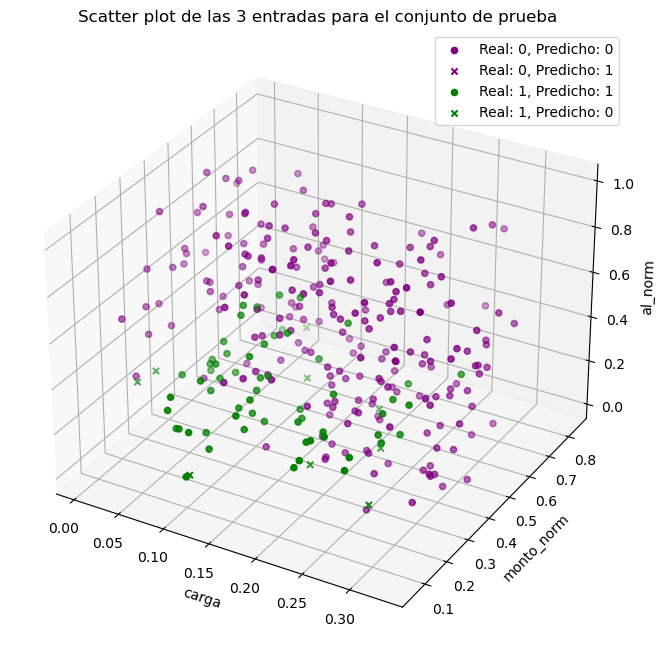

In [36]:
# Obtener las características
carga_test = x_test[:, 0]
monto_norm_test = x_test[:, 1]
al_norm_test = x_test[:, 2]

# ----------------- # Gráfica de los resultados # ------------------- #
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Puntos de la clase 0 (mora_bool = 0)
mask_0 = (d_test == 0) & (y_pred_test[:, 0] == 0)
ax.scatter(carga_test[mask_0], monto_norm_test[mask_0], al_norm_test[mask_0], color='purple', label='Real: 0, Predicho: 0')

mask_0_incorrect = (d_test == 0) & (y_pred_test[:, 0] == 1)
ax.scatter(carga_test[mask_0_incorrect], monto_norm_test[mask_0_incorrect], al_norm_test[mask_0_incorrect], color='purple', marker='x', label='Real: 0, Predicho: 1')

# Puntos de la clase 1 (mora_bool = 1)
mask_1 = (d_test == 1) & (y_pred_test[:, 0] == 1)
ax.scatter(carga_test[mask_1], monto_norm_test[mask_1], al_norm_test[mask_1], color='green', label='Real: 1, Predicho: 1')

mask_1_incorrect = (d_test == 1) & (y_pred_test[:, 0] == 0)
ax.scatter(carga_test[mask_1_incorrect], monto_norm_test[mask_1_incorrect], al_norm_test[mask_1_incorrect], color='green', marker='x', label='Real: 1, Predicho: 0')

ax.set_xlabel('carga')
ax.set_ylabel('monto_norm')
ax.set_zlabel('al_norm')
ax.set_title('Scatter plot de las 3 entradas para el conjunto de prueba')
ax.legend()

plt.show()